![Crisp](img/logo.png)
# <img src="img/weather.svg" alt="icon" width="40"/>  Weather Analytics with Sales and Inventory data

[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-orange?logo=google-colab&style=for-the-badge)](https://colab.research.google.com/github/gocrisp/blueprints/blob/main/notebooks/crisp_weather_analytics.ipynb)
[![Open in Vertex AI](https://img.shields.io/badge/Open%20in-Vertex%20AI%20Workbench-brightgreen?logo=google-cloud&style=for-the-badge)](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/gocrisp/blueprints/blob/main/notebooks/crisp_weather_analytics.ipynb)
[![Open in Databricks](https://img.shields.io/badge/Try-databricks-red?logo=databricks&style=for-the-badge)](https://www.databricks.com/try-databricks)
[![View on GitHub](https://img.shields.io/badge/View%20on-GitHub-lightgrey?logo=github&style=for-the-badge)](https://github.com/gocrisp/blueprints/blob/main/notebooks/crisp_weather_analytics.ipynb)

> To deploy a notebook in Databricks:
> 1. Open your workspace and navigate to the folder where you want to import the notebook.
> 2. Click the triple-dot icon (next to the Share button).
> 3. Select **Import**, then choose **URL** as the import method.
> 4. Paste the notebook's URL, then click **Import** to complete the process.

This notebook demonstrates how to leverage weather data in predicting sales and finding inventory gaps.

## Set the required environment variables

In [1]:
import os

os.environ["ACCOUNT_ID"] = "999999"
# os.environ["CONNECTOR_ID"] = "7240"
retailer = "target"

### Run Crisp common

This notebook uses the [crisp_common.ipynb](./crisp_common.ipynb) notebook to load the common functions and variables. The `crisp_common.ipynb` notebook contains the common functions and variables that are used across the Crisp notebooks.

In [ ]:
if not os.path.exists("crisp_common.ipynb"):
    print("Downloading crisp_common.ipynb")
    !wget https://raw.githubusercontent.com/gocrisp/analytics-blueprints-public/main/notebooks/crisp_common.ipynb -O crisp_common.ipynb
else:
    print("crisp_common.ipynb already exists")

%run crisp_common.ipynb

## Import globally-used dependencies

In [3]:
import numpy as np
import folium
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import widgets, interact


### Load the data from BigQuery

We'll load data from the `fact_sales` and `fact_weather` tables.

In [4]:
dim_product = "exp_harmonized_retailer_dim_product"
dim_store = "exp_harmonized_retailer_dim_store"
fact_sales = "exp_harmonized_retailer_fact_sales"
fact_inventory = "exp_harmonized_retailer_fact_inventory_store"
fact_weather = "exp_harmonized_fact_weather"

In [5]:
%%load date_product_store_sales
WITH
  dim_product AS(
  SELECT
    product_id,
    product,
    product_category,
    product_sub_category
  FROM
    `{project}`.`{dataset}`.`{dim_product}`
  WHERE
    retailer = '{retailer}'
  ),
  fact_sales AS(
  SELECT
    store_id,
    product_id,
    sales_quantity,
    date_key
  FROM
    `{project}`.`{dataset}`.`{fact_sales}`
  WHERE
    retailer = '{retailer}'
  )
SELECT
    dim_product.product_id,
    dim_product.product,
    dim_product.product_category,
    dim_product.product_sub_category,
    fact_sales.store_id,
    fact_sales.date_key,
    SUM(fact_sales.sales_quantity) AS sales_quantity
FROM
    fact_sales
INNER JOIN dim_product USING (product_id)
GROUP BY 1, 2, 3, 4, 5, 6

In [6]:
date_product_store_sales.head()

,product_id,product,product_category,product_sub_category,store_id,date_key,sales_quantity
0,132,LunaTech Cinema 55,TV & Audio,TVs,690794113278183045,2024-09-12,0
1,132,LunaTech Cinema 55,TV & Audio,TVs,528294245447988846,2024-09-12,0
2,132,LunaTech Cinema 55,TV & Audio,TVs,572787042526322468,2024-09-13,0
3,132,LunaTech Cinema 55,TV & Audio,TVs,155651560324665982,2024-09-14,0
4,132,LunaTech Cinema 55,TV & Audio,TVs,254490231383561319,2024-09-16,0


## Load stores information
We will retrieve store details, such as location and identification information, so you can map sales and weather data to specific store locations.

In [7]:
%%load stores_df
SELECT
    store_id,
    store_zip,
    store_state,
    store_latitude,
    store_longitude
FROM
    `{project}`.`{dataset}`.`{dim_store}`
WHERE
    retailer = '{retailer}'

In [8]:
stores_df = stores_df.dropna()
stores_df

,store_id,store_zip,store_state,store_latitude,store_longitude
0,6628229265896171,06042,CT,41.810376500,-72.549135400
1,731768505406763229,06053,CT,41.710900500,-72.762979000
2,564676580930017061,06082,CT,41.995773300,-72.581940600
3,938296014196475287,06095,CT,41.890784100,-72.652129000
4,731425052078486739,06111,CT,41.660981100,-72.725048200
...,...,...,...,...,...
172,595027950968563710,19468,PA,40.210767500,-75.498370100
173,775096491431547873,19560,PA,40.397834000,-75.929449000
174,525096589161912108,19606,PA,40.308795800,-75.859386800
175,806973478844236319,19610,PA,40.359491200,-75.983375600


## Load products information
We will gather basic product details, such as product IDs and names, so you can categorize your sales data.

In [9]:
%%load products_df
SELECT
    product_id,
    product
FROM
    `{project}`.`{dataset}`.`{dim_product}`

In [10]:
products_df

,product_id,product
0,101,LunaTech Titan
1,102,LunaTech Axis
2,103,LunaTech Ion
3,104,LunaTech Helios
4,105,LunaTech Edge
...,...,...
75,176,LunaTech Steam Iron
76,177,LunaTech Water Filter
77,178,LunaTech Washer
78,179,LunaTech Dryer


## Load weather data
We will retrieve weather data associated with each store and date, so we can analyze how weather conditions impact those stores.

In [11]:
%%load weather_df
SELECT
    date_key,
    store_zip,
    average_temperature_fahrenheit,
    maximum_temperature_fahrenheit,
    minimum_temperature_fahrenheit,
    precipitation_inches,
    pressure_sea_level_millibars,
    relative_humidity_percent,
    sky_coverage_percent,
    snowfall_inches,
    wind_direction_degrees,
    wind_speed_mph,
    wind_gust_mph,
    allergy_index,
    asthma_index,
    flu_index,
    is_forecast
FROM
    `{project}`.`{dataset}`.`{fact_weather}`

## Visualize correlation between weather data columns
We will calculate correlations between weather data columns (e.g., temperature, humidity, and rainfall) and display them in a heat map. Understanding these correlations will help us determine which combinations of weather attributes are most relevant to include in a machine learning model, ensuring the model is efficient and avoids redundancy. 

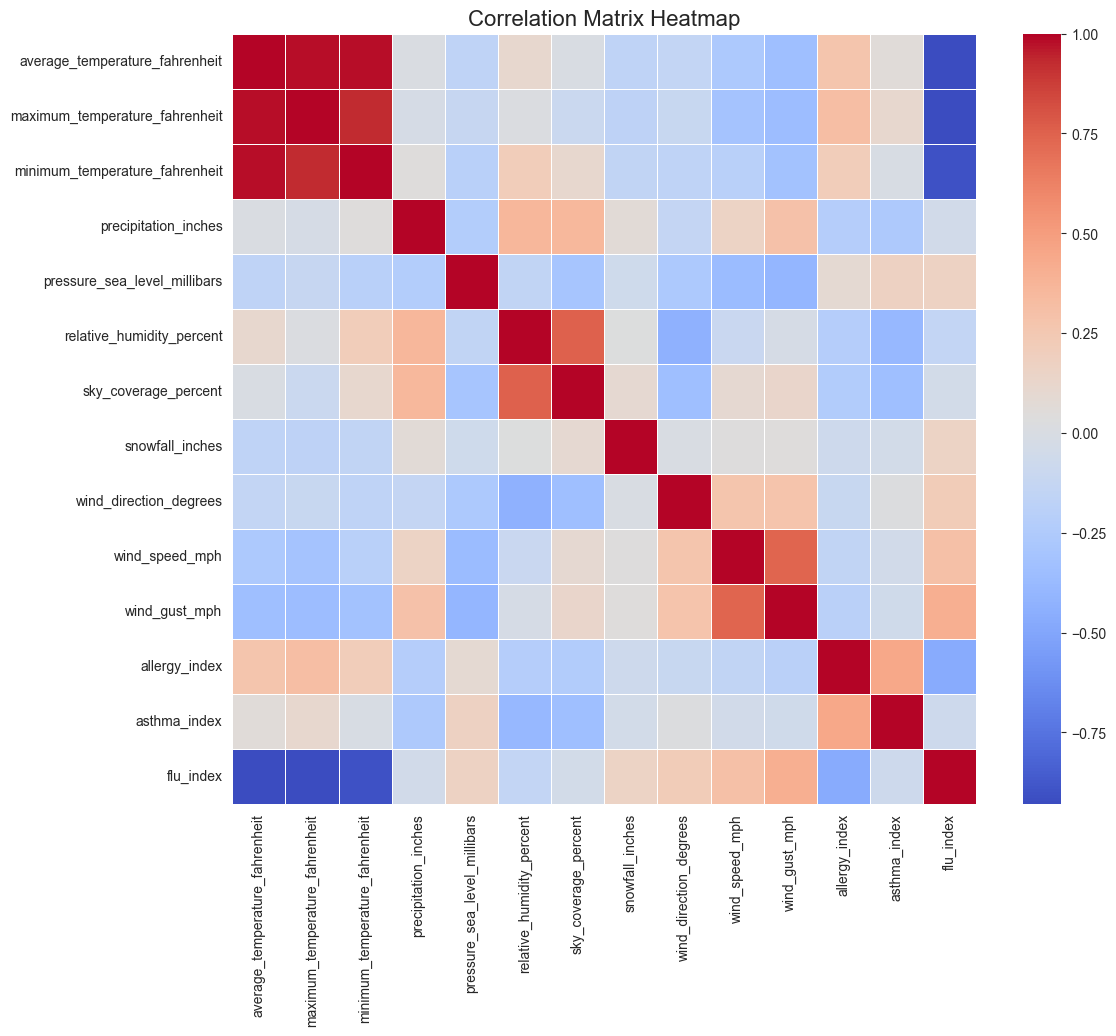

In [12]:
numeric_weather_df = weather_df.select_dtypes(include=[np.number]).drop(
    ["store_zip"], axis=1, errors="ignore"
)

# Calculating the correlation matrix
correlation_matrix = numeric_weather_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()

## Combine weather data and sales data
We will merge sales data, store details, and weather data, so you can analyze combined datasets.

In [13]:
sales_with_stores = date_product_store_sales.merge(stores_df, on="store_id")
weather_df["date_key"] = pd.to_datetime(weather_df["date_key"])
sales_with_stores["date_key"] = pd.to_datetime(sales_with_stores["date_key"])
weather_df["store_zip"] = weather_df["store_zip"].astype(str)
sales_with_stores["store_zip"] = sales_with_stores["store_zip"].astype(str)
sales_weather_df = sales_with_stores.merge(
    weather_df, on=["date_key", "store_zip"], how="inner"
)
sales_weather_df["sales_quantity"] = sales_weather_df["sales_quantity"].fillna(0)
sales_weather_df

,product_id,product,product_category,product_sub_category,store_id,date_key,sales_quantity,store_zip,store_state,store_latitude,...,relative_humidity_percent,sky_coverage_percent,snowfall_inches,wind_direction_degrees,wind_speed_mph,wind_gust_mph,allergy_index,asthma_index,flu_index,is_forecast
0,132,LunaTech Cinema 55,TV & Audio,TVs,690794113278183045,2024-09-12,0,11722,NY,40.773148100,...,55.0,15.0,0.0,121.0,8.0,13.0,8,4,1,False
1,132,LunaTech Cinema 55,TV & Audio,TVs,528294245447988846,2024-09-12,0,19095,PA,40.075954400,...,36.0,7.0,0.0,122.0,9.0,11.0,10,4,1,False
2,132,LunaTech Cinema 55,TV & Audio,TVs,572787042526322468,2024-09-13,0,19152,PA,40.051190800,...,NaN,NaN,0.0,NaN,NaN,NaN,10,5,0,False
3,132,LunaTech Cinema 55,TV & Audio,TVs,155651560324665982,2024-09-14,0,06901,CT,41.055030000,...,NaN,NaN,0.0,NaN,NaN,NaN,10,6,0,False
4,132,LunaTech Cinema 55,TV & Audio,TVs,254490231383561319,2024-09-16,0,11375,NY,40.720876700,...,50.0,64.0,0.0,82.0,18.0,11.0,8,8,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5547995,180,LunaTech Induction Cooktop,Home Appliances,Home Appliances,889142332902569689,2024-09-23,5,16803,PA,40.813133500,...,91.0,86.0,0.0,135.0,11.0,23.0,5,0,2,False
5547996,180,LunaTech Induction Cooktop,Home Appliances,Home Appliances,7243408426042915,2024-11-01,5,19001,PA,40.125300000,...,23.0,28.0,0.0,252.0,26.0,33.0,10,5,1,False
5547997,180,LunaTech Induction Cooktop,Home Appliances,Home Appliances,651287248604405781,2024-11-03,5,06385,CT,41.376567500,...,34.0,2.0,0.0,87.0,12.0,23.0,0,1,6,False
5547998,180,LunaTech Induction Cooktop,Home Appliances,Home Appliances,561013862688954317,2024-12-24,5,18045,PA,40.712572600,...,55.0,57.0,0.7,278.0,11.0,15.0,0,1,9,False


## Find correlation between per sub-category sales and weather features
We will calculate correlations between weather attributes and sales quantities for each product sub-category, so we can identify weather factors affecting different sub-categories.

In [14]:
sales_weather_df["category_subcategory"] = (
    sales_weather_df["product_category"]
    + " - "
    + sales_weather_df["product_sub_category"]
)

unique_categories = sales_weather_df["category_subcategory"].unique()
correlation_data = []

for category in unique_categories:
    category_df = sales_weather_df[sales_weather_df["category_subcategory"] == category]

    correlations_prep = category_df[
        [
            "sales_quantity",
            "average_temperature_fahrenheit",
            "maximum_temperature_fahrenheit",
            "minimum_temperature_fahrenheit",
            "precipitation_inches",
            "pressure_sea_level_millibars",
            "relative_humidity_percent",
            "sky_coverage_percent",
            "snowfall_inches",
            "wind_direction_degrees",
            "wind_speed_mph",
            "wind_gust_mph",
            "allergy_index",
            "asthma_index",
            "flu_index",
        ]
    ]

    correlations_prep = correlations_prep.fillna(0).apply(
        pd.to_numeric, errors="coerce"
    )
    all_correlations = correlations_prep.corr()
    if "sales_quantity" in all_correlations.columns:
        correlations = all_correlations["sales_quantity"].drop(["sales_quantity"])
        correlation_data.append(
            {"category_subcategory": category, **correlations.to_dict()}
        )

correlation_df = pd.DataFrame(correlation_data)
pivot_table = correlation_df.set_index("category_subcategory")

## Visualize correlations between sales and weather features
We will create a heatmap to visualize the correlations between sales and weather attributes across product categories and subcategories.

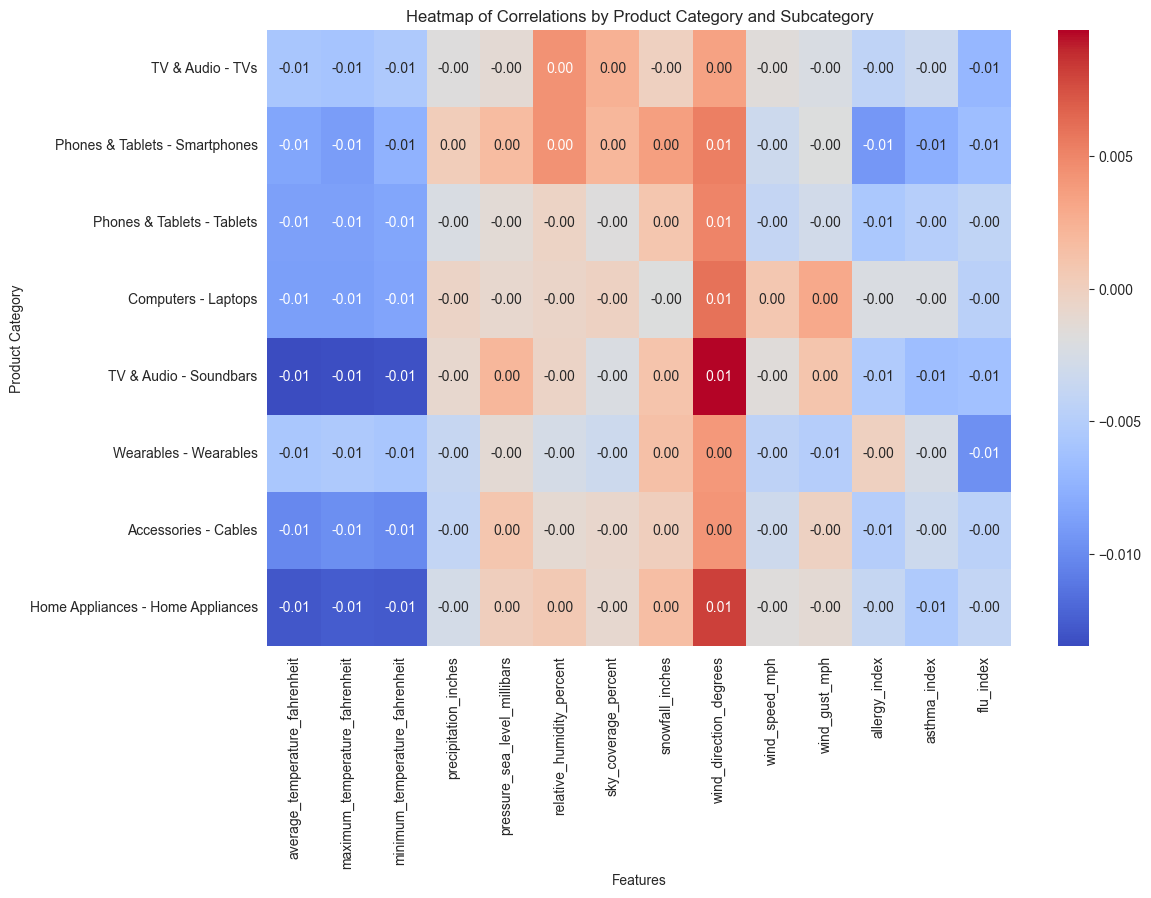

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Correlations by Product Category and Subcategory")
plt.ylabel("Product Category")
plt.xlabel("Features")
plt.show()

# Analyze how sales in a single category correlate with weather data
We will analyze correlations between weather attributes and sales quantities for a specific product category (e.g., Construction). 

In [16]:
product_by_id = sales_weather_df[['product_id', 'product']].copy().drop_duplicates().set_index('product_id')
def analyze_category(selected_category):
    category_df = sales_weather_df[sales_weather_df["product_category"] == selected_category]
    unique_products = category_df["product_id"].unique()

    correlation_data = []

    for product_id in unique_products:
        # Filter data for the current product
        product_df = category_df[category_df["product_id"] == product_id]

        # Select relevant columns for correlation calculation
        correlations_prep = product_df[
            [
                "sales_quantity",
                "average_temperature_fahrenheit",
                "maximum_temperature_fahrenheit",
                "minimum_temperature_fahrenheit",
                "precipitation_inches",
                "pressure_sea_level_millibars",
                "relative_humidity_percent",
                "sky_coverage_percent",
                "snowfall_inches",
                "wind_direction_degrees",
                "wind_speed_mph",
                "wind_gust_mph",
                "allergy_index",
                "asthma_index",
                "flu_index",
            ]
        ]

        correlations_prep = correlations_prep.apply(pd.to_numeric, errors="coerce")
        correlations = correlations_prep.corr()["sales_quantity"].drop(["sales_quantity"])
        correlation_data.append({"product_id": product_id, **correlations.to_dict()})

    correlation_df = pd.DataFrame(correlation_data)

    if correlation_df.empty:
        print("No data available for the selected category.")
        return

    correlation_df = correlation_df.merge(product_by_id, left_on="product_id", right_index=True)
    pivot_table = correlation_df.set_index("product")
    pivot_table.drop("product_id", axis=1, inplace=True)

    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Heatmap of Correlations for Category: {selected_category}")
    plt.ylabel("Product ID")
    plt.xlabel("Features")
    plt.show()

# Create a dropdown widget for category selection
category_dropdown = widgets.Dropdown(
    options=sales_weather_df["product_category"].unique(),
    description="Category:",
)

# Link the dropdown to the function
interact(analyze_category, selected_category=category_dropdown)

interactive(children=(Dropdown(description='Category:', options=('TV & Audio', 'Phones & Tablets', 'Computers'…

<function __main__.analyze_category(selected_category)>

## Create a weather-based sales predictor for each product
We will train a machine learning model for each product in the specified category to learn the relationship between weather attributes and sales quantities based on historical data.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

unique_products = sales_weather_df["product_id"].unique()

predictors = {}

for product_id in unique_products:
    product_df = sales_weather_df[sales_weather_df["product_id"] == product_id].sample(
        frac=0.1
    )  # Sample 10% of the data to speed up training

    feature_columns = [
        "average_temperature_fahrenheit",
        "maximum_temperature_fahrenheit",
        "minimum_temperature_fahrenheit",
        "precipitation_inches",
        "pressure_sea_level_millibars",
        "relative_humidity_percent",
        "sky_coverage_percent",
        "snowfall_inches",
        "wind_direction_degrees",
        "wind_speed_mph",
        "wind_gust_mph",
        "allergy_index",
        "asthma_index",
        "flu_index",
    ]
    X = product_df[feature_columns]
    y = product_df["sales_quantity"]

    X = X.apply(pd.to_numeric, errors="coerce").fillna(0)
    y = pd.to_numeric(y, errors="coerce").fillna(0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    predictors[product_id] = {"model": model, "mse": mse, "r2": r2}

predictors

In [26]:
forecast_data = weather_df[weather_df["is_forecast"]]
forecast_data

,date_key,store_zip,average_temperature_fahrenheit,maximum_temperature_fahrenheit,minimum_temperature_fahrenheit,precipitation_inches,pressure_sea_level_millibars,relative_humidity_percent,sky_coverage_percent,snowfall_inches,wind_direction_degrees,wind_speed_mph,wind_gust_mph,allergy_index,asthma_index,flu_index,is_forecast
8755,2025-01-13,16803,24.97,32.47,17.47,0.02,1014.80,65.0,77.0,0.0,248.0,14.3,18.1,0,1,10,True
8756,2025-01-13,16801,25.58,33.08,18.08,0.02,1014.80,65.0,77.0,0.0,248.0,14.3,18.1,0,1,9,True
9134,2025-01-19,10309,30.94,38.08,23.81,0.02,1018.31,49.0,60.0,0.0,256.0,25.9,35.2,0,1,8,True
9135,2025-01-19,06401,30.55,37.29,23.81,0.02,1017.18,53.0,34.0,0.0,256.0,21.8,31.3,0,0,9,True
9136,2025-01-19,06704,27.90,35.09,20.72,0.02,1016.79,52.0,37.0,0.0,256.0,18.5,31.1,0,0,9,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67694,2025-01-17,06901,23.82,30.64,17.01,0.00,1014.41,41.0,26.0,0.0,303.0,25.2,24.5,0,8,10,True
67695,2025-01-17,06611,21.36,27.64,15.08,0.00,1013.63,42.0,13.0,0.0,303.0,26.0,27.8,0,3,10,True
67696,2025-01-17,06801,20.94,28.88,12.99,0.00,1013.89,34.0,18.0,0.0,303.0,20.2,28.1,0,1,10,True
67697,2025-01-17,06611,21.36,27.64,15.08,0.00,1013.63,42.0,13.0,0.0,303.0,26.0,27.8,0,3,10,True


## Run predictors on all forecast data
We will apply the models we created in the previous step to weather forecast data, so we can estimate sales quantities for upcoming days.

In [27]:
forecasted_sales = {}

feature_columns = [
    "average_temperature_fahrenheit",
    "maximum_temperature_fahrenheit",
    "minimum_temperature_fahrenheit",
    "precipitation_inches",
    "pressure_sea_level_millibars",
    "relative_humidity_percent",
    "sky_coverage_percent",
    "snowfall_inches",
    "wind_direction_degrees",
    "wind_speed_mph",
    "wind_gust_mph",
    "allergy_index",
    "asthma_index",
    "flu_index",
]

X_forecast = forecast_data[feature_columns]
X_forecast = X_forecast.apply(pd.to_numeric, errors="coerce").fillna(0)

for product_id, predictor in predictors.items():
    model = predictor["model"]
    predictions = model.predict(X_forecast)
    forecasted_sales[product_id] = predictions

forecast_results = pd.DataFrame(forecasted_sales)

forecast_results["store_zip"] = forecast_data["store_zip"].values
forecast_results["date_key"] = forecast_data["date_key"].values

forecast_results = forecast_results.melt(
    id_vars=["store_zip", "date_key"],
    var_name="product_id",
    value_name="14d_expected_sales",
)

forecast_results

,store_zip,date_key,product_id,14d_expected_sales
0,16803,2025-01-13,132,1.478333
1,16801,2025-01-13,132,1.478333
2,10309,2025-01-19,132,0.580000
3,06401,2025-01-19,132,0.770000
4,06704,2025-01-19,132,0.700000
...,...,...,...,...
197115,06901,2025-01-17,180,1.625000
197116,06611,2025-01-17,180,1.100000
197117,06801,2025-01-17,180,1.626667
197118,06611,2025-01-17,180,1.100000


# Prepare expected sales information
We will process the predicted sales data and associate it with stores and products, so we can pinpoint stores and products with the highest expected sales.

In [28]:
forecast_results["store_zip"] = forecast_results["store_zip"].astype(str)
stores_df["store_zip"] = stores_df["store_zip"].astype(str)
forecast_results = forecast_results.merge(stores_df, on="store_zip", how="inner")

# Calculate total expected sales per store and product
sales_by_store = (
    forecast_results.groupby(["store_id", "product_id"])["14d_expected_sales"]
    .sum()
    .reset_index()
)
sales_by_store = sales_by_store[sales_by_store["14d_expected_sales"] > 0]
# Sort by total expected sales in descending order
sales_by_store = sales_by_store.sort_values("14d_expected_sales", ascending=False)

# Display summary of top stores by expected sales
print("\nTop Stores by Expected Sales with Product Detail:")
sales_by_store[["store_id", "product_id", "14d_expected_sales"]]


Top Stores by Expected Sales with Product Detail:


,store_id,product_id,14d_expected_sales
2782,191387243841401417,163,51.562667
13822,970646382757881218,163,51.562667
563,14901479966135402,104,50.209333
5043,385177824898762087,104,50.209333
2622,156296375261649319,163,50.047667
...,...,...,...
4712,356400903526727933,173,9.910000
10392,712475924380251464,173,9.790000
10792,775096491431547873,173,9.665000
7512,549750867161034949,173,8.900000


## Load inventory data
We will retrieve inventory information for the most recent 30 days, so you can analyze on-hand stock levels by store and product.

In [29]:
%%load inventory_df
SELECT
    date_key,
    store_id,
    product_id,
    on_hand_quantity
FROM
    `{project}`.`{dataset}`.`{fact_inventory}`
WHERE 
    retailer = '{retailer}'
    AND DATE(date_key) >= DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY)

In [30]:
inventory_df = (
    inventory_df.sort_values("date_key").groupby(["store_id", "product_id"]).tail(1)
)
inventory_df

,date_key,store_id,product_id,on_hand_quantity
192780,2024-12-30,731425052078486739,178,9
193243,2024-12-30,311411960115189143,178,21
187544,2024-12-30,681598983793975192,176,7
12139,2024-12-30,680876676423986889,105,15
193024,2024-12-30,913302017082922663,178,13
...,...,...,...,...
68794,2024-12-30,236797218327345875,128,7
173238,2024-12-30,747709117339197862,170,14
68874,2024-12-30,746257431106729281,128,8
173268,2024-12-30,115988163515673948,170,15


## Find inventory gaps at stores
We will compare expected sales forecasts with current inventory levels, so you can identify inventory gaps and prioritize restocking efforts.

In [31]:
# Merge sales forecast with current inventory levels
sales_by_store["product_id"] = sales_by_store["product_id"].astype(int)
inventory_df["product_id"] = inventory_df["product_id"].astype(int)
inventory_analysis = sales_by_store.merge(
    inventory_df, on=["store_id", "product_id"], how="left"
)

# Fill missing inventory with 0 (stores with no inventory data)
inventory_analysis["on_hand_quantity"] = (
    inventory_analysis["on_hand_quantity"].fillna(0.0).astype(float)
)

# Calculate inventory gap
inventory_analysis["inventory_gap"] = (
    inventory_analysis["on_hand_quantity"] - inventory_analysis["14d_expected_sales"]
)

# Filter to show only stores with insufficient inventory
insufficient_inventory = inventory_analysis[
    inventory_analysis["inventory_gap"] < -1
].sort_values("inventory_gap")
# Add product names to the analysis
insufficient_inventory = insufficient_inventory.merge(
    products_df[["product_id", "product"]], on="product_id", how="left"
)

print("\nStores with Insufficient Inventory:")
insufficient_inventory[
    [
        "store_id",
        "product_id",
        "product",
        "on_hand_quantity",
        "14d_expected_sales",
        "inventory_gap",
    ]
]


Stores with Insufficient Inventory:


,store_id,product_id,product,on_hand_quantity,14d_expected_sales,inventory_gap
0,14901479966135402,104,LunaTech Helios,0.0,50.209333,-50.209333
1,385177824898762087,104,LunaTech Helios,0.0,50.209333,-50.209333
2,156296375261649319,163,Ethernet Cable,0.0,50.047667,-50.047667
3,406537362510008225,163,Ethernet Cable,0.0,49.037000,-49.037000
4,14901479966135402,118,LunaTab Max,0.0,48.755000,-48.755000
...,...,...,...,...,...,...
12619,150624119308978254,180,LunaTech Induction Cooktop,18.0,19.020000,-1.020000
12620,655970720420525744,106,LunaTech Spark,19.0,20.020000,-1.020000
12621,1256909618105974,111,LunaTab Mini,17.0,18.010667,-1.010667
12622,439464825557464331,112,LunaTech Slate,18.0,19.010000,-1.010000


## Visualize inventory gaps
We will generate an interactive map that highlights stores and products with insufficient inventory. Store markers are displayed on the map with their size proportional to the inventory gap.

In [33]:
# Map the stores with insufficient inventory; make the size of the marker proportional to the inventory gap
insufficient_inventory_with_location = insufficient_inventory.merge(
    stores_df[["store_id", "store_latitude", "store_longitude"]],
    on="store_id",
    how="left",
)
center = stores_df[["store_latitude", "store_longitude"]].mean()
m = folium.Map(location=[center["store_latitude"], center["store_longitude"]], zoom_start=10)

for _, row in insufficient_inventory_with_location.sample(frac=0.01).iterrows():
    folium.CircleMarker(
        location=[row["store_latitude"], row["store_longitude"]],
        radius=0.3 * abs(row["inventory_gap"]),
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.3,
        popup=f"Store ID: {row['store_id']}<br>Product: {row['product']}<br>Inventory Gap: {row['inventory_gap']:.2f}",
    ).add_to(m)

m